In [116]:
import cv2
import glob
import numpy as np
from scipy.ndimage import rotate

from matplotlib.pyplot import imshow
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [117]:
def mask_img(input, mask):
    return ((mask/255)*input).astype(np.uint8)

def mask_blend(input, mask):
    return cv2.addWeighted(input, 1, mask, 0.25, 0)

def imfill(input):
    output = np.zeros(input.shape, dtype=np.uint8)
    cnts, _ = cv2.findContours(input, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output, cnts, -1, 255, thickness=cv2.FILLED)
    return output

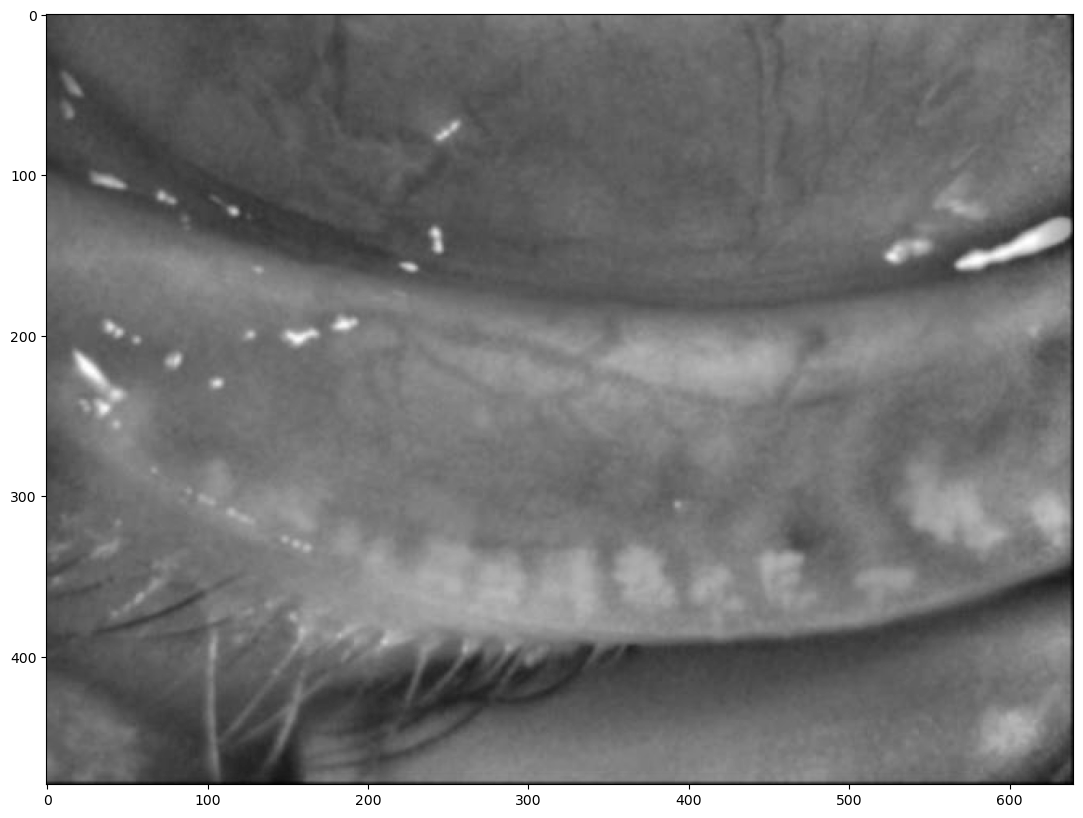

In [118]:
img_no = 237
filelist = sorted(glob.glob('../img/raw/*.jpeg'))
img_bgr = cv2.imread(filelist[img_no])
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
imshow(img, cmap='gray')

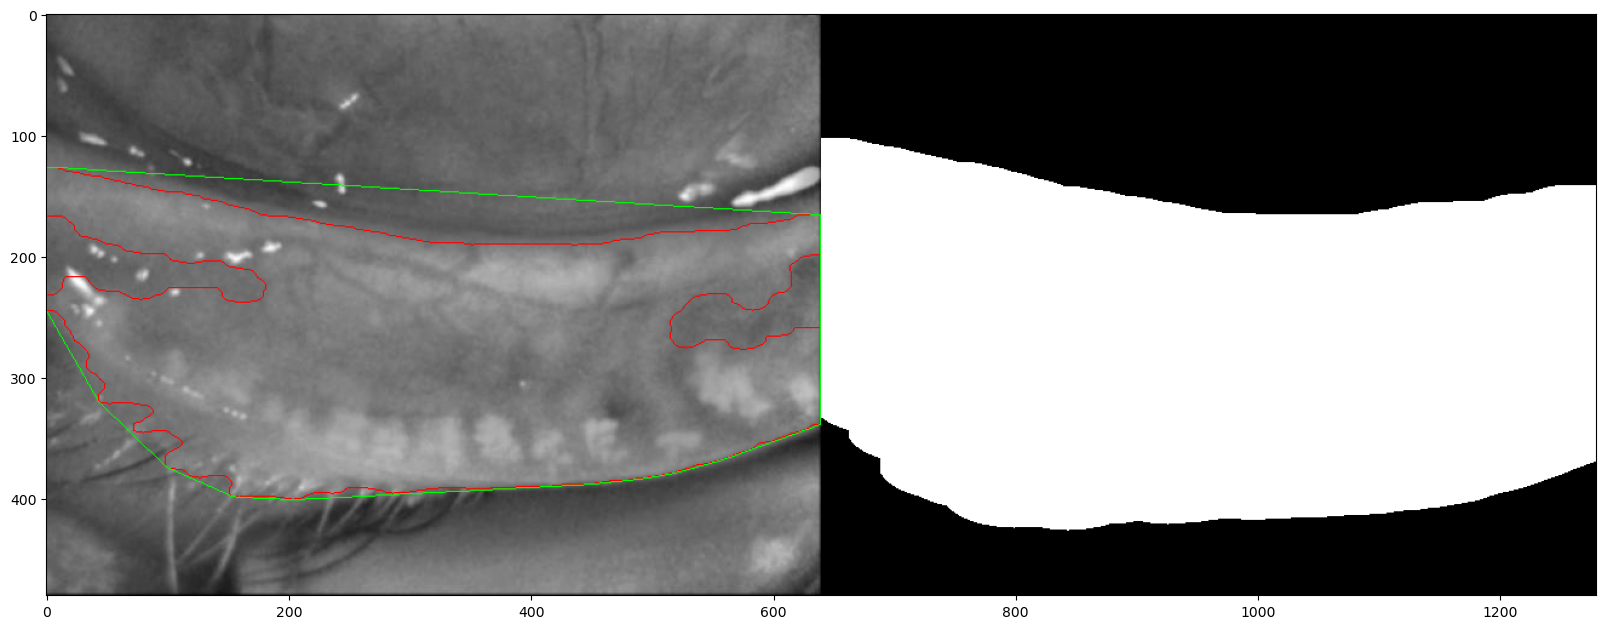

In [119]:
# Find ROI Mask
thr, res_thr_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
res_mor = cv2.morphologyEx(res_thr_img, cv2.MORPH_OPEN, kernel=kernel)
res_mor2 = cv2.morphologyEx(res_mor, cv2.MORPH_CLOSE, kernel=kernel)
cnts, _ = cv2.findContours(res_mor2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask_cnt = np.zeros(img.shape, dtype=np.uint8)
res_cnt = img_bgr.copy()
if len(cnts) != 0:
    sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt = sorted_cnts[0]
    max_hull = cv2.convexHull(max_cnt)    
    cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)
    cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)

    cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 50))
    mask_cnt2 = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel, borderValue=0)
    mask_cnt3 = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel, borderValue=0)

imshow(cv2.hconcat([res_cnt, cv2.cvtColor(mask_cnt3, cv2.COLOR_GRAY2BGR)]), cmap='gray')

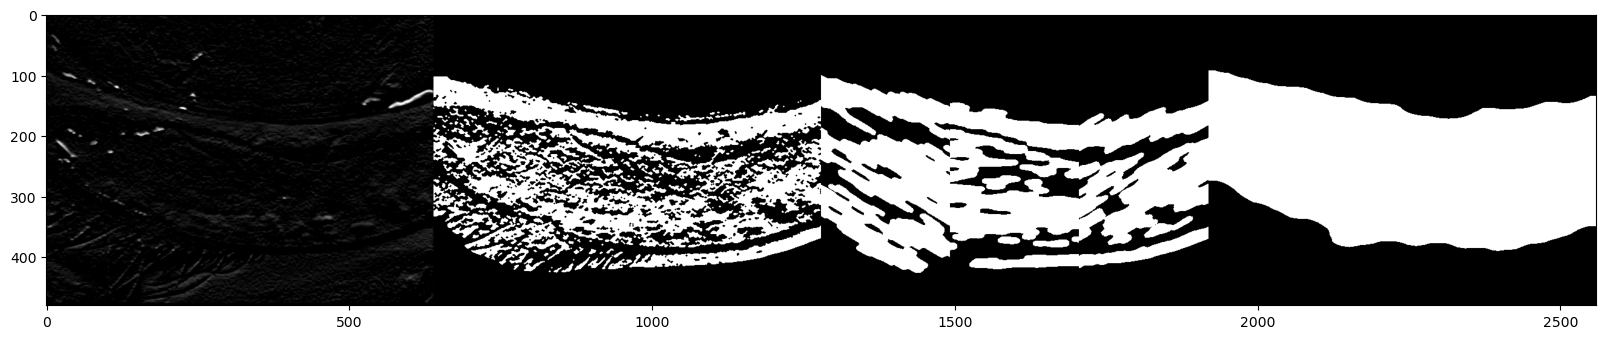

In [120]:
# Improve ROI Mask
res_sbl = cv2.Sobel(img, dx=0, dy=1, ddepth=-1, ksize=3)
_, res_sbl2 = cv2.threshold(res_sbl*mask_cnt3, 0, 255, cv2.THRESH_OTSU)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
res_sbl_mor = cv2.morphologyEx(res_sbl2, cv2.MORPH_CLOSE, kernel=kernel)
res_sbl_mor = cv2.morphologyEx(res_sbl_mor, cv2.MORPH_OPEN, kernel=kernel)

h, w = res_sbl.shape
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 5))
left = res_sbl_mor[:, 0:int(w/3)]
kernel2 = rotate(kernel, 150)
left = cv2.morphologyEx(left, cv2.MORPH_CLOSE, kernel=kernel2)
middle = res_sbl_mor[:, int(w/3):int(2*w/3)]
middle = cv2.morphologyEx(middle, cv2.MORPH_CLOSE, kernel=kernel)
right = res_sbl_mor[:, int(2*w/3):]
kernel2 = rotate(kernel, 30)
right = cv2.morphologyEx(right, cv2.MORPH_CLOSE, kernel=kernel2)
res_sbl_mor2 = cv2.hconcat([left, middle, right])

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 10))
left = res_sbl_mor2[:, 0:int(w/3)]
kernel2 = rotate(kernel, 150)
left = cv2.morphologyEx(left, cv2.MORPH_OPEN, kernel=kernel2)
middle = res_sbl_mor2[:, int(w/3):int(2*w/3)]
middle = cv2.morphologyEx(middle, cv2.MORPH_OPEN, kernel=kernel)
right = res_sbl_mor2[:, int(2*w/3):]
kernel2 = rotate(kernel, 30)
right = cv2.morphologyEx(right, cv2.MORPH_OPEN, kernel=kernel2)
res_sbl_mor3 = cv2.hconcat([left, middle, right])

cnts, _ = cv2.findContours(res_sbl_mor3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask_cnt = np.zeros(img.shape, dtype=np.uint8)
res_cnt = img_bgr.copy()
if len(cnts) != 0:
    sorted_cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    max_cnt = sorted_cnts[0]
    max_hull = cv2.convexHull(max_cnt)
    cv2.drawContours(mask_cnt, [max_cnt], -1, 255, thickness=cv2.FILLED)
    cv2.drawContours(res_cnt, [max_cnt], -1, [255, 0, 0], thickness=1)
    cv2.drawContours(res_cnt, [max_hull], -1, [0, 255, 0], thickness=1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100, 50))
    mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_CLOSE, kernel=kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 20))
    mask_cnt = cv2.morphologyEx(mask_cnt, cv2.MORPH_DILATE, kernel=kernel)
    mask_cnt_fin = imfill(mask_cnt)
    imshow(cv2.hconcat([res_sbl, res_sbl_mor, res_sbl_mor3, mask_cnt_fin]), cmap='gray')

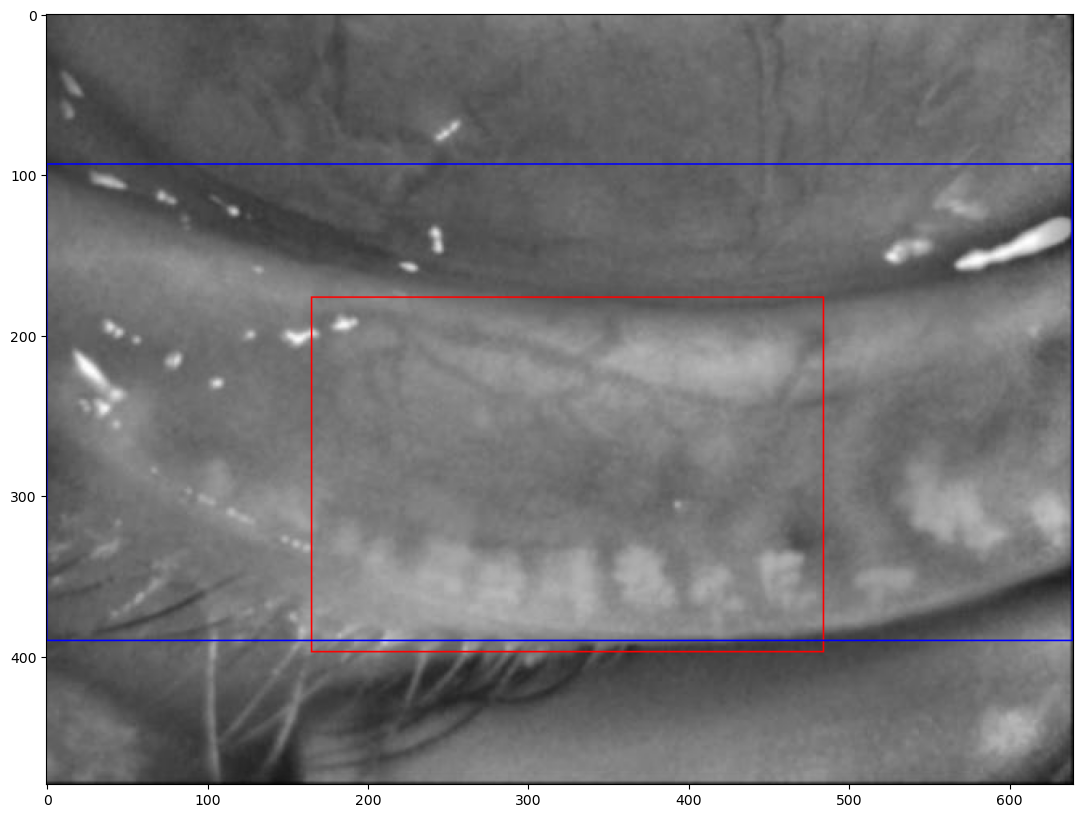

In [150]:
# Bounding box and crop
img_bbox = img_bgr.copy()
bbox = cv2.boundingRect(mask_cnt_fin)
mom = cv2.moments(mask_cnt_fin, binaryImage=True)
cx = int(mom["m10"]/mom["m00"])
cy = int(mom["m01"]/mom["m00"])
bbox_small = [cx-int(bbox[2]/4), cy-2*int(bbox[3]/8), 2*int(bbox[2]/4), 6*int(bbox[3]/8)]
cv2.rectangle(img_bbox, bbox_small, color=[255, 0, 0])
cv2.rectangle(img_bbox, bbox, color=[0, 0, 255])
mask_box = np.zeros(img.shape, dtype=np.uint8)
cv2.rectangle(mask_box, bbox_small, color=255, thickness=cv2.FILLED)
imshow(img_bbox)

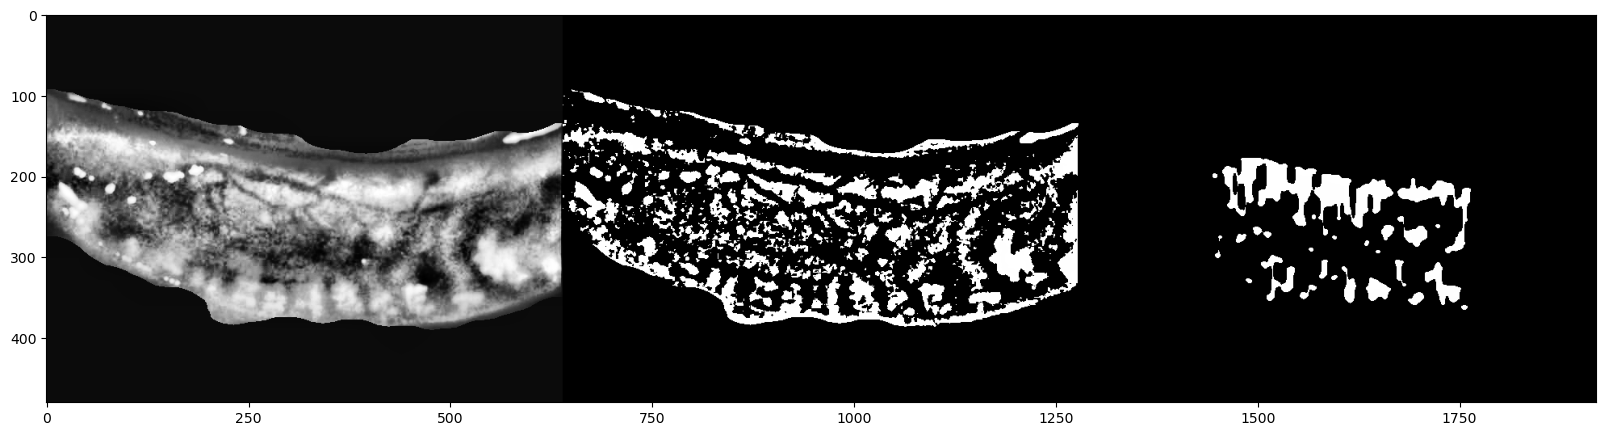

In [151]:
# Find Candidate Glands
# clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
# res_histeq = clahe.apply(mask_img(img, mask_cnt_fin))
res_histeq = cv2.equalizeHist(mask_img(img, mask_cnt_fin))
thr, res_thr_histeq = cv2.threshold(res_histeq, 225, 255, cv2.THRESH_BINARY)
bsize = 51
res_athr_histeq = cv2.adaptiveThreshold(res_histeq, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blockSize=bsize, C=-16)
res_athr_histeq  = res_thr_histeq +  res_athr_histeq

# Eliminate borders
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (bsize, bsize))
mask_cnt_small = cv2.morphologyEx(mask_cnt_fin, cv2.MORPH_ERODE, kernel=kernel)
res_athr_histeq_mor  = mask_img(res_athr_histeq ,mask_cnt_small&mask_box)

# Clean artifacts
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 7))
res_athr_histeq_mor  = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_OPEN, kernel=kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 10))
res_athr_histeq_mor  = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_CLOSE, kernel=kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
res_athr_histeq_mor  = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_OPEN, kernel=kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 20))
res_athr_histeq_mor  = cv2.morphologyEx(res_athr_histeq_mor, cv2.MORPH_CLOSE, kernel=kernel)
res_candidate_glands = res_athr_histeq_mor

imshow(cv2.hconcat([res_histeq, res_athr_histeq, res_candidate_glands]), cmap='gray')


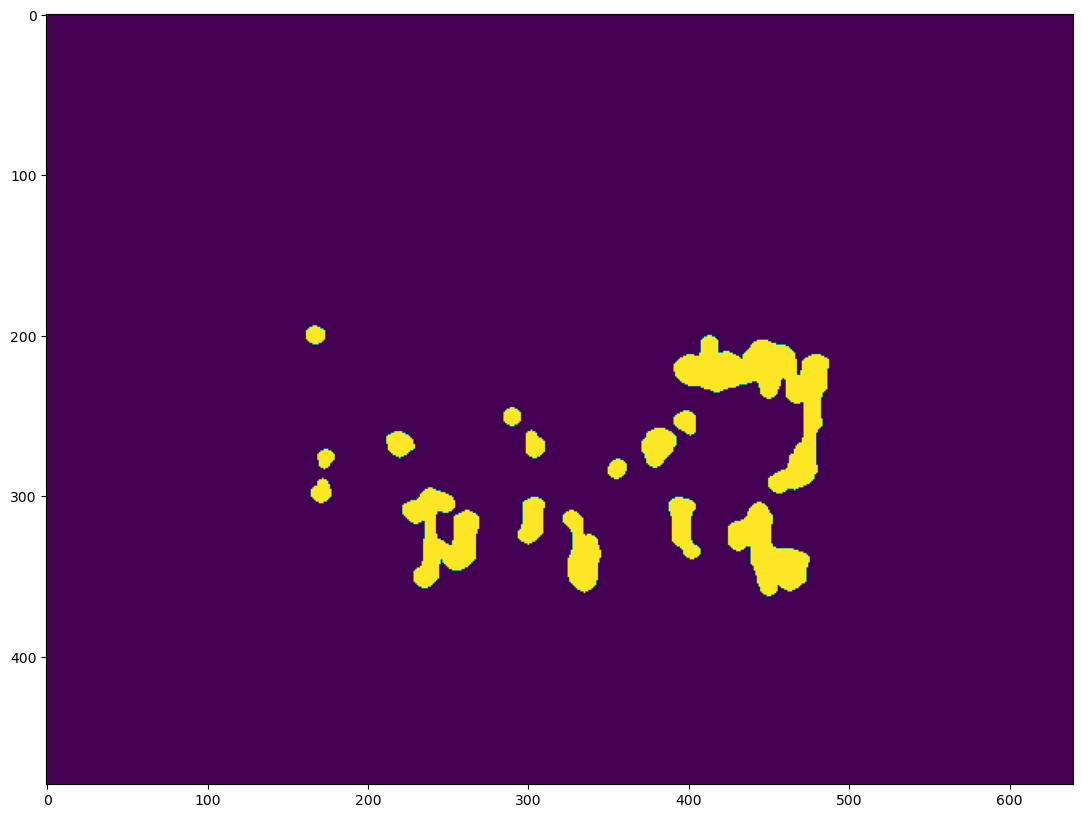

In [190]:
# Blob Analysis
cnts, _ = cv2.findContours(res_candidate_glands, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
res_cnt = img_bgr.copy()
res_glands = np.zeros(img.shape, dtype=np.uint8)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
for cnt in cnts:
    area = cv2.contourArea(cnt)
    _, (w, h), angle = cv2.minAreaRect(cnt)
    if w < h:
        angle = 90-angle
    else:
        angle = -angle

    if (area>200 and (angle>45 or angle<-45)):
        canvas = np.zeros(img.shape, dtype=np.uint8)
        cv2.drawContours(canvas, [cnt], -1, [255, 0, 0], thickness=cv2.FILLED)
        canvas = cv2.morphologyEx(canvas, cv2.MORPH_DILATE, kernel=kernel)
        res_glands = res_glands | canvas

imshow(res_glands)

Total gland intensity(%) in img  237 :  14.625106613941227


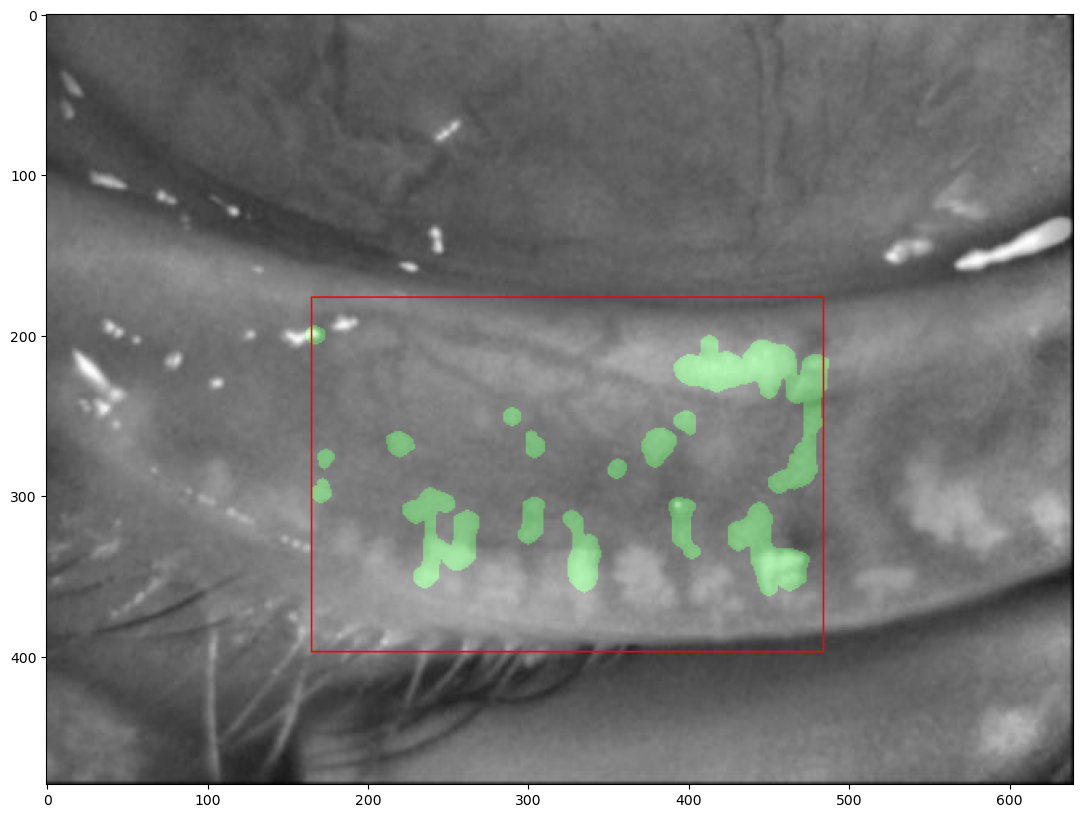

In [200]:
# Final Image
img_res = img_bgr.copy()
img_res[:,:,1] = mask_blend(img_res[:,:,1], res_glands)
cv2.rectangle(img_res, bbox_small, color=[255, 0, 0])  

# Grade Calculation
total_roi = cv2.countNonZero(mask_box*mask_cnt_fin)
total_gland = cv2.countNonZero(res_glands)
print("Total gland intensity(%) in img ", str(img_no),": ", str(total_gland/total_roi*100))

imshow(img_res)